In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully!")
print("=" * 60)

All libraries imported successfully!


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset from Google Drive
# NOTE: User should update this path to their actual file location
file_path = '/content/drive/MyDrive/dataset/bank.csv'  # Update this path

# Read the dataset
df = pd.read_csv(file_path, delimiter=',')

print("Dataset loaded successfully!")
print("=" * 60)
print(f"Dataset Shape: {df.shape}")
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")
print("=" * 60)
print("\nColumn Names:")
print(df.columns.tolist())
print("=" * 60)
print("\nFirst 5 Rows:")
print(df.head())
print("=" * 60)
print("\nDataset Info:")
print(df.info())
print("=" * 60)
print("\nBasic Statistics:")
print(df.describe())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully!
Dataset Shape: (11162, 17)
Number of Rows: 11162
Number of Columns: 17

Column Names:
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']

First 5 Rows:
   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   m

In [ ]:
# Check for missing values
print("Missing Values Analysis:")
print("=" * 60)
missing_values = df.isnull().sum()
print(missing_values)
print(f"\nTotal missing values: {missing_values.sum()}")
print("=" * 60)

# Check target variable distribution
print("\nTarget Variable Distribution:")
print("=" * 60)
print(df['deposit'].value_counts())
print("\nPercentage Distribution:")
print(df['deposit'].value_counts(normalize=True) * 100)
print("=" * 60)

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategorical Columns:")
print(categorical_cols)
print(f"Count: {len(categorical_cols)}")
print("=" * 60)
print("\nNumerical Columns:")
print(numerical_cols)
print(f"Count: {len(numerical_cols)}")
print("=" * 60)

# Display unique values for categorical columns
print("\nUnique Values in Categorical Columns:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")
    print(f"  Values: {df[col].unique()[:10]}")  # Show first 10 unique values
    print()

Missing Values Analysis:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

Total missing values: 0

Target Variable Distribution:
deposit
no     5873
yes    5289
Name: count, dtype: int64

Percentage Distribution:
deposit
no     52.616019
yes    47.383981
Name: proportion, dtype: float64

Categorical Columns:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']
Count: 10

Numerical Columns:
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Count: 7

Unique Values in Categorical Columns:
job: 12 unique values
  Values: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown']

marital: 3 unique values
  Values: ['married' 'single' 'divo

In [ ]:
# PREPROCESSING STEP 1: Handle Missing Values and Duplicates
print("PREPROCESSING STEP 1: Missing Values & Duplicates")
print("=" * 60)

# Check for missing values
missing_before = df.isnull().sum().sum()
print(f"Missing values before: {missing_before}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows")
else:
    print("No duplicates found")

# Handle 'unknown' values in categorical columns (treated as missing)
unknown_counts = {}
for col in categorical_cols:
    if 'unknown' in df[col].values:
        unknown_counts[col] = (df[col] == 'unknown').sum()

print(f"\\nColumns with 'unknown' values:")
for col, count in unknown_counts.items():
    print(f"  {col}: {count} ({count/len(df)*100:.2f}%)")

print(f"\\nTotal records after preprocessing: {len(df)}")
print("=" * 60)

PREPROCESSING STEP 1: Missing Values & Duplicates
Missing values before: 0
Duplicate rows: 0
No duplicates found
\nColumns with 'unknown' values:
  job: 70 (0.63%)
  education: 497 (4.45%)
  contact: 2346 (21.02%)
  poutcome: 8326 (74.59%)
\nTotal records after preprocessing: 11162


In [ ]:
# PREPROCESSING STEP 2: Outlier Detection and Handling
print("PREPROCESSING STEP 2: Outlier Detection & Handling")
print("=" * 60)

# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

# Store original size
original_size = len(df)

# Detect outliers in key numerical columns
outlier_summary = {}
for col in ['age', 'balance', 'duration', 'campaign']:
    count, lower, upper = detect_outliers_iqr(df, col)
    outlier_summary[col] = {
        'count': count,
        'percentage': (count/len(df))*100,
        'lower_bound': lower,
        'upper_bound': upper
    }
    print(f"\\n{col}:")
    print(f"  Outliers detected: {count} ({count/len(df)*100:.2f}%)")
    print(f"  Bounds: [{lower:.2f}, {upper:.2f}]")

# Decision: Keep outliers but use robust scaling
print("\\n" + "=" * 60)
print("DECISION: Retain outliers as they represent legitimate customer data.")
print("Strategy: Use RobustScaler which is resistant to outliers.")
print("=" * 60)

# For extreme outliers in 'duration' and 'campaign', we'll cap them
# Duration > 3600 seconds (1 hour) is extremely rare
extreme_duration = (df['duration'] > 3600).sum()
print(f"\\nExtreme duration outliers (>3600s): {extreme_duration}")

# Campaign > 50 is extremely rare
extreme_campaign = (df['campaign'] > 50).sum()
print(f"Extreme campaign outliers (>50): {extreme_campaign}")

# Cap extreme values (Winsorization)
df['duration_capped'] = df['duration'].clip(upper=df['duration'].quantile(0.99))
df['campaign_capped'] = df['campaign'].clip(upper=df['campaign'].quantile(0.99))

print("\\nApplied Winsorization (capping at 99th percentile) for duration and campaign.")
print("=" * 60)

PREPROCESSING STEP 2: Outlier Detection & Handling
\nage:
  Outliers detected: 171 (1.53%)
  Bounds: [6.50, 74.50]
\nbalance:
  Outliers detected: 1055 (9.45%)
  Bounds: [-2257.00, 4087.00]
\nduration:
  Outliers detected: 636 (5.70%)
  Bounds: [-399.00, 1033.00]
\ncampaign:
  Outliers detected: 601 (5.38%)
  Bounds: [-2.00, 6.00]
\n============================================================
DECISION: Retain outliers as they represent legitimate customer data.
Strategy: Use RobustScaler which is resistant to outliers.
\nExtreme duration outliers (>3600s): 1
Extreme campaign outliers (>50): 1
\nApplied Winsorization (capping at 99th percentile) for duration and campaign.


In [1]:
# PREPROCESSING STEP 3: Encode Categorical Variables
print("PREPROCESSING STEP 3: Categorical Variable Encoding")
print("=" * 60)

# Create a copy for encoding
df_encoded = df.copy()

# Separate target variable
target = df_encoded['deposit'].map({'yes': 1, 'no': 0})
df_encoded = df_encoded.drop('deposit', axis=1)

# Get categorical columns (excluding target)
cat_cols = [col for col in categorical_cols if col != 'deposit']

print(f"Categorical columns to encode: {len(cat_cols)}")
print(cat_cols)

# Binary encoding for binary features
binary_features = ['default', 'housing', 'loan']
for col in binary_features:
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].map({'yes': 1, 'no': 0})
        print(f"  Binary encoded: {col}")

# One-hot encoding for multi-class categorical features
multi_class_features = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
df_encoded = pd.get_dummies(df_encoded, columns=multi_class_features, drop_first=True)

print(f"\nShape after encoding: {df_encoded.shape}")
print(f"Original features: {len(df.columns) - 1}")  # Excluding target
print(f"Features after one-hot encoding: {df_encoded.shape[1]}")
print("=" * 60)

# Use capped features
if 'duration_capped' in df_encoded.columns:
    df_encoded['duration'] = df_encoded['duration_capped']
    df_encoded = df_encoded.drop('duration_capped', axis=1)

if 'campaign_capped' in df_encoded.columns:
    df_encoded['campaign'] = df_encoded['campaign_capped']
    df_encoded = df_encoded.drop('campaign_capped', axis=1)

print("Final encoded features:")
print(df_encoded.columns.tolist())
print("=" * 60)

PREPROCESSING STEP 3: Categorical Variable Encoding


NameError: name 'df' is not defined

In [ ]:
# PREPROCESSING STEP 4: Train-Validation-Test Split
print("PREPROCESSING STEP 4: Data Splitting")
print("=" * 60)

# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    df_encoded, target, test_size=0.2, random_state=42, stratify=target
)

# Second split: separate validation set from remaining data (20% of 80% = 16% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"Total samples: {len(df_encoded)}")
print(f"Training set: {len(X_train)} ({len(X_train)/len(df_encoded)*100:.1f}%)")
print(f"Validation set: {len(X_val)} ({len(X_val)/len(df_encoded)*100:.1f}%)")
print(f"Test set: {len(X_test)} ({len(X_test)/len(df_encoded)*100:.1f}%)")

print("\\nClass distribution:")
print(f"Training - No: {(y_train==0).sum()}, Yes: {(y_train==1).sum()}")
print(f"Validation - No: {(y_val==0).sum()}, Yes: {(y_val==1).sum()}")
print(f"Test - No: {(y_test==0).sum()}, Yes: {(y_test==1).sum()}")
print("=" * 60)

PREPROCESSING STEP 4: Data Splitting
Total samples: 11162
Training set: 7143 (64.0%)
Validation set: 1786 (16.0%)
Test set: 2233 (20.0%)
\nClass distribution:
Training - No: 3758, Yes: 3385
Validation - No: 940, Yes: 846
Test - No: 1175, Yes: 1058


In [ ]:
# PREPROCESSING STEP 5: Feature Scaling
print("PREPROCESSING STEP 5: Feature Scaling")
print("=" * 60)

# Use StandardScaler for better PCA performance
scaler = StandardScaler()

# Fit on training data only to prevent data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier manipulation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("StandardScaler applied to all features")
print(f"Training set mean: {X_train_scaled.mean().mean():.6f}")
print(f"Training set std: {X_train_scaled.std().mean():.6f}")
print("=" * 60)

# Display sample of scaled data
print("\\nSample of scaled training data:")
print(X_train_scaled.head())
print("=" * 60)

PREPROCESSING STEP 5: Feature Scaling
StandardScaler applied to all features
Training set mean: 0.000000
Training set std: 1.000070
\nSample of scaled training data:
           age   default   balance   housing      loan       day  duration  \
4108  2.251568 -0.123319 -0.111131 -0.950409 -0.386415  0.047837 -0.474058   
3944  1.748084 -0.123319  0.468725  1.052179  2.587895 -0.782979 -0.324057   
7595 -0.853249 -0.123319 -0.512651 -0.950409 -0.386415  1.116030 -1.089368   
2289 -0.937163 -0.123319 -0.512651  1.052179 -0.386415 -1.257731 -0.636304   
3469  0.321547 -0.123319  0.540550 -0.950409 -0.386415  1.590782  0.064722   

      campaign     pdays  previous  ...  month_jul  month_jun  month_mar  \
4108 -0.656897  1.229957  2.254085  ...  -0.392612  -0.350623  -0.158477   
3944 -0.656897  1.193518  0.080164  ...  -0.392612  -0.350623  -0.158477   
7595  4.845014 -0.482662 -0.354620  ...  -0.392612  -0.350623  -0.158477   
2289 -0.198404 -0.482662 -0.354620  ...  -0.392612   2.852064

In [ ]:
pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis=1)\
  .to_csv("/content/drive/MyDrive/processed_train_data.csv", index=False)

# Validation set
pd.concat([X_val_scaled, y_val.reset_index(drop=True)], axis=1)\
  .to_csv("/content/drive/MyDrive/processed_val_data.csv", index=False)

# Test set
pd.concat([X_test_scaled, y_test.reset_index(drop=True)], axis=1)\
  .to_csv("/content/drive/MyDrive/processed_test_data.csv", index=False)

print("All processed data saved to CSV files!")

All processed data saved to CSV files!


In [ ]:

# PREPROCESSING STEP 6: Handle Class Imbalance using SMOTE
print("PREPROCESSING STEP 6: Class Imbalance Handling")
print("=" * 60)

print("Before SMOTE:")
print(f"  Class 0 (No): {(y_train==0).sum()}")
print(f"  Class 1 (Yes): {(y_train==1).sum()}")
print(f"  Imbalance ratio: {(y_train==0).sum()/(y_train==1).sum():.2f}:1")

# Apply SMOTE only to training data
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\\nAfter SMOTE:")
print(f"  Class 0 (No): {(y_train_balanced==0).sum()}")
print(f"  Class 1 (Yes): {(y_train_balanced==1).sum()}")
print(f"  Imbalance ratio: {(y_train_balanced==0).sum()/(y_train_balanced==1).sum():.2f}:1")

print("\\nSMOTE successfully balanced the training set by generating synthetic")
print("minority class samples. Validation and test sets remain imbalanced to")
print("reflect real-world distribution.")
print("=" * 60)

PREPROCESSING STEP 6: Class Imbalance Handling
Before SMOTE:
  Class 0 (No): 3758
  Class 1 (Yes): 3385
  Imbalance ratio: 1.11:1
\nAfter SMOTE:
  Class 0 (No): 3758
  Class 1 (Yes): 3758
  Imbalance ratio: 1.00:1
\nSMOTE successfully balanced the training set by generating synthetic
minority class samples. Validation and test sets remain imbalanced to
reflect real-world distribution.


STARTING EXPLORATORY DATA ANALYSIS (EDA)


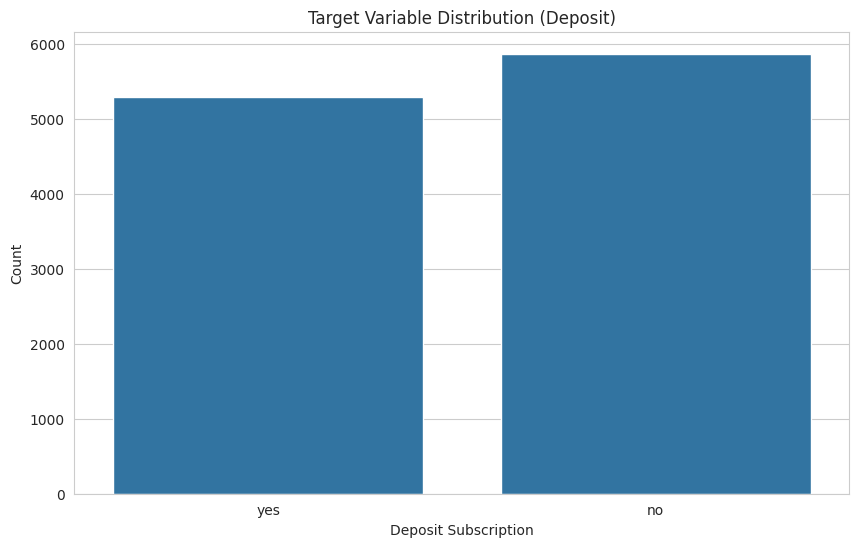

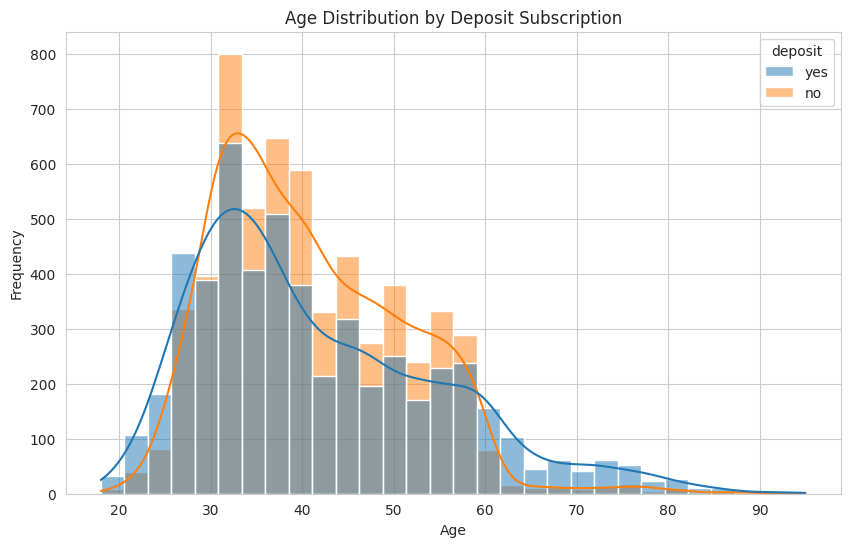

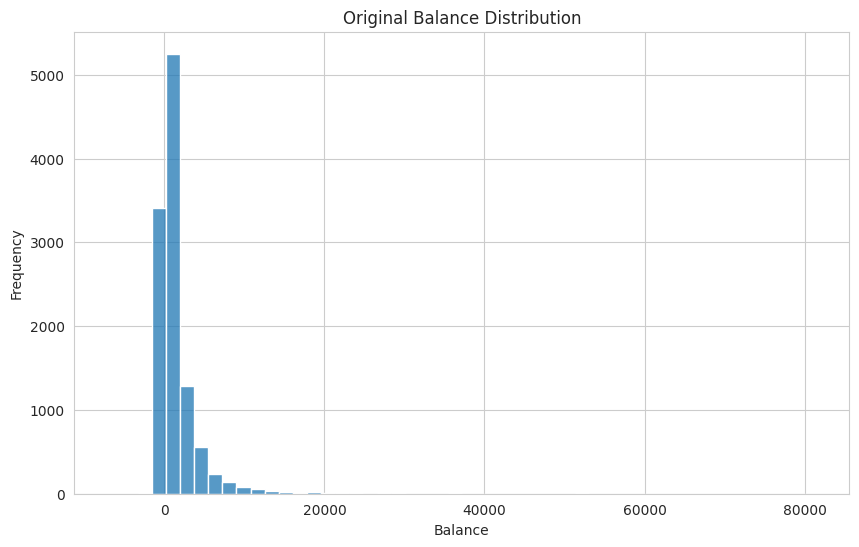

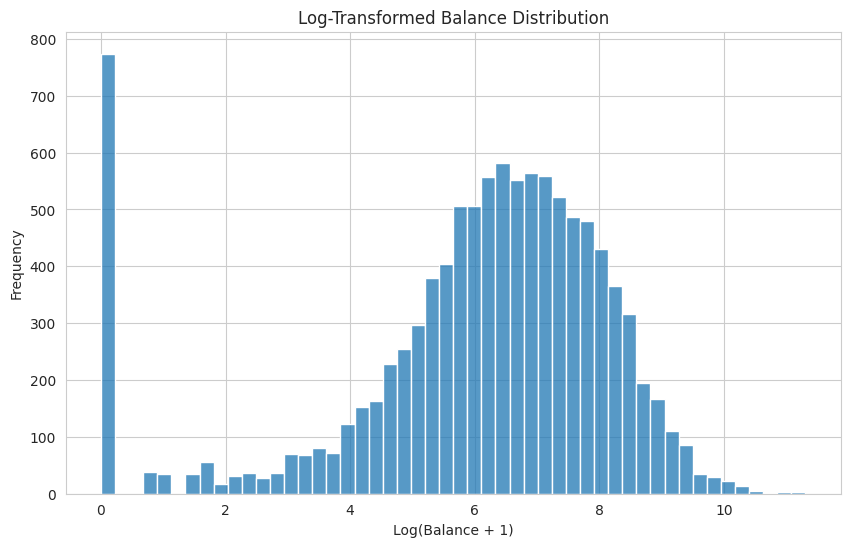

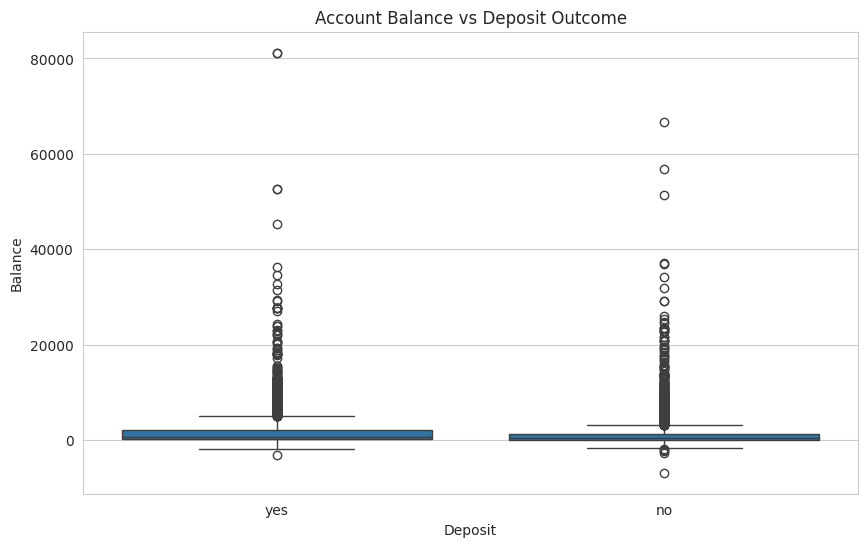

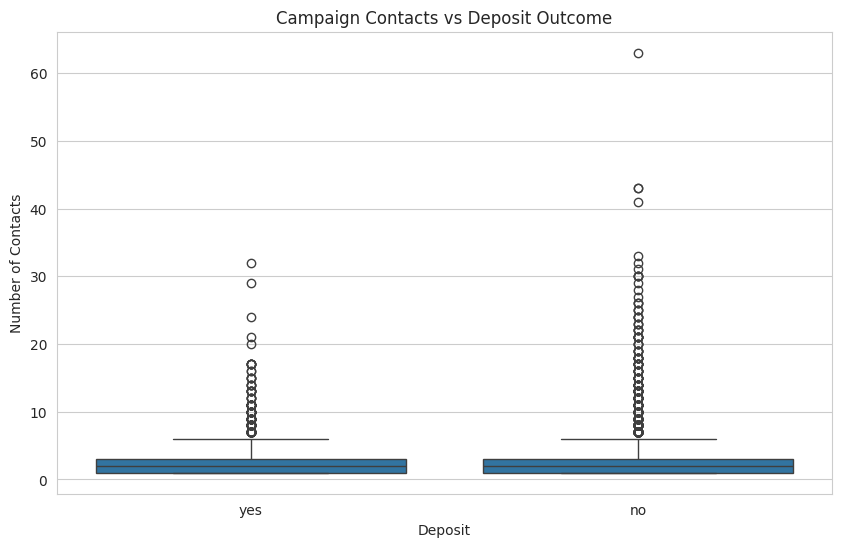

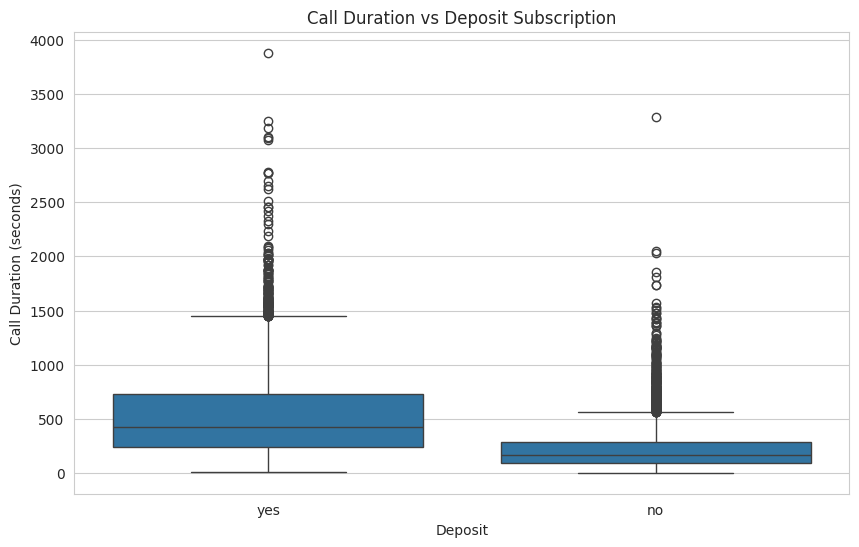

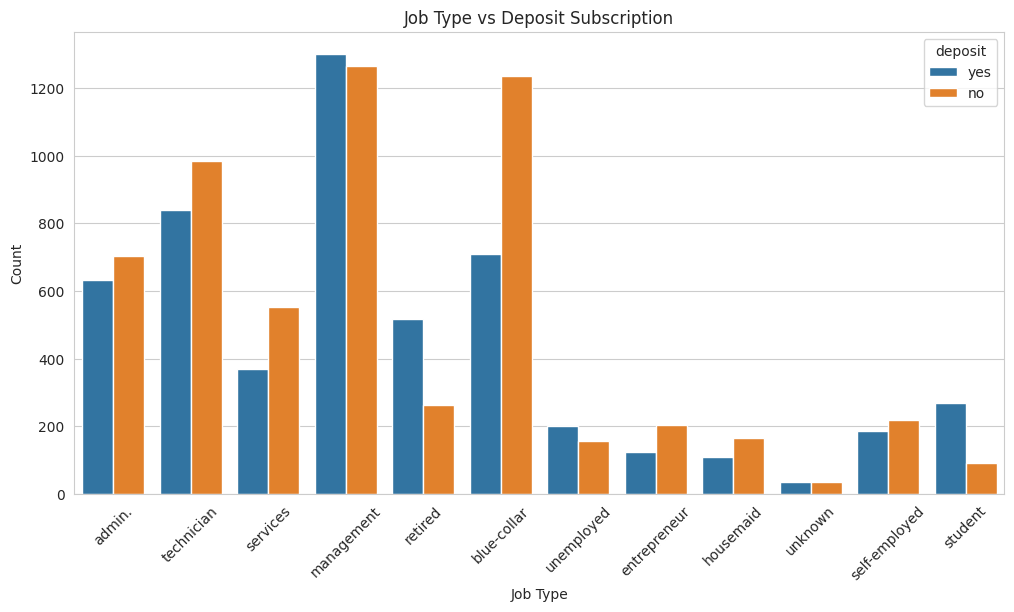

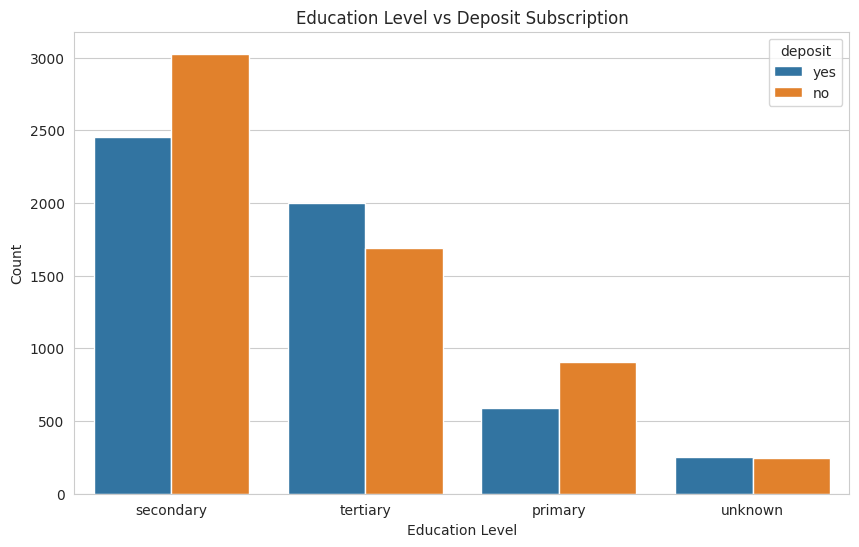

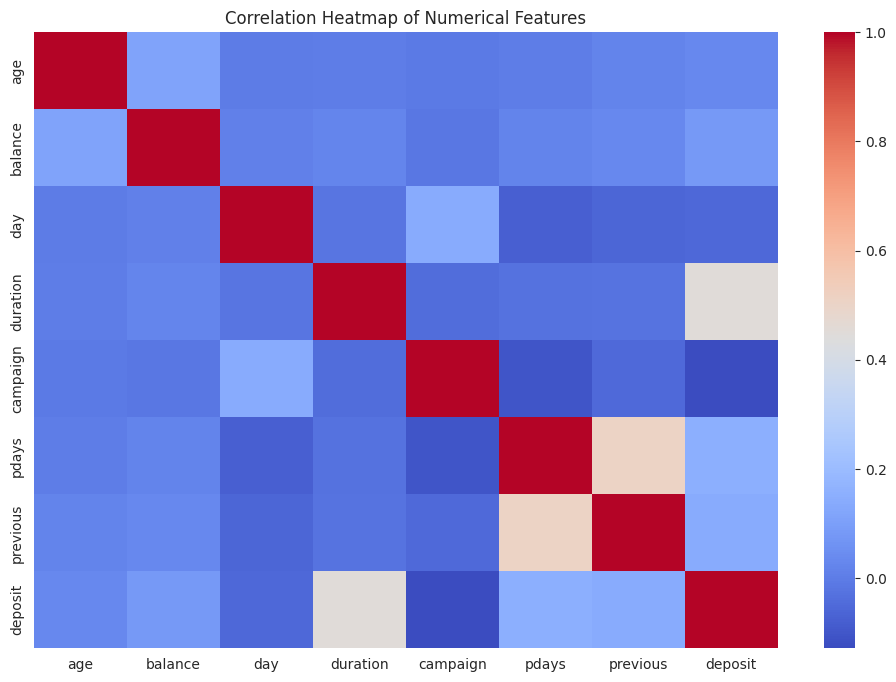

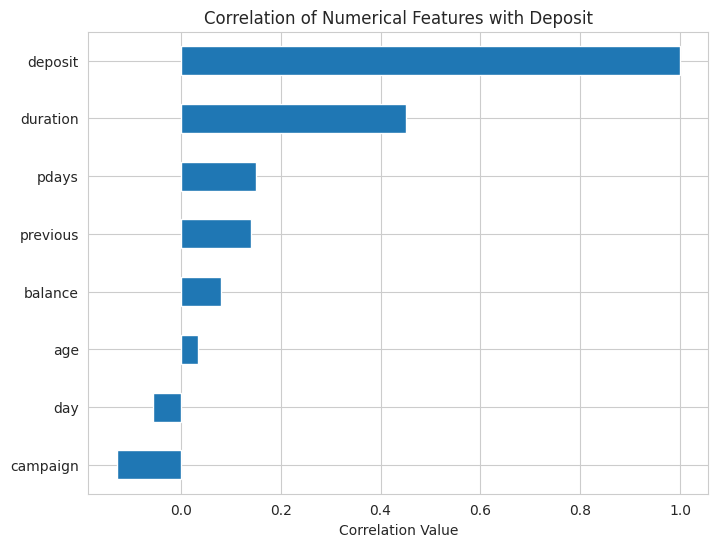

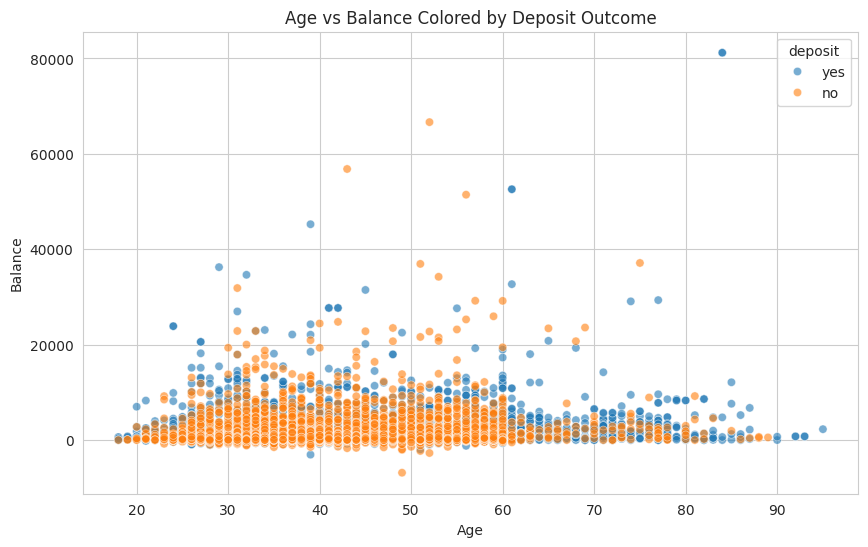

EDA COMPLETED SUCCESSFULLY


In [ ]:

# ===============================
# COMPLETE EXPLORATORY DATA ANALYSIS (EDA)
# ===============================

print("STARTING EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 80)

# Ensure target is readable
df_eda = df.copy()

# -------------------------------
# 1. Target Variable Distribution
# -------------------------------
plt.figure()
sns.countplot(x=df_eda['deposit'])
plt.title("Target Variable Distribution (Deposit)")
plt.xlabel("Deposit Subscription")
plt.ylabel("Count")
plt.show()

# -------------------------------
# 2. Age Distribution by Target
# -------------------------------
plt.figure()
sns.histplot(data=df_eda, x='age', hue='deposit', bins=30, kde=True)
plt.title("Age Distribution by Deposit Subscription")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# -------------------------------
# 3. Balance Distribution (Original)
# -------------------------------
plt.figure()
sns.histplot(df_eda['balance'], bins=50)
plt.title("Original Balance Distribution")
plt.xlabel("Balance")
plt.ylabel("Frequency")
plt.show()

# -------------------------------
# 4. Balance Distribution (Log Transformed)
# -------------------------------
plt.figure()
sns.histplot(np.log1p(df_eda['balance']), bins=50)
plt.title("Log-Transformed Balance Distribution")
plt.xlabel("Log(Balance + 1)")
plt.ylabel("Frequency")
plt.show()

# -------------------------------
# 5. Boxplot: Balance vs Deposit
# -------------------------------
plt.figure()
sns.boxplot(data=df_eda, x='deposit', y='balance')
plt.title("Account Balance vs Deposit Outcome")
plt.xlabel("Deposit")
plt.ylabel("Balance")
plt.show()

# -------------------------------
# 6. Boxplot: Campaign Contacts vs Deposit
# -------------------------------
plt.figure()
sns.boxplot(data=df_eda, x='deposit', y='campaign')
plt.title("Campaign Contacts vs Deposit Outcome")
plt.xlabel("Deposit")
plt.ylabel("Number of Contacts")
plt.show()

# -------------------------------
# 7. Boxplot: Call Duration vs Deposit
# -------------------------------
plt.figure()
sns.boxplot(data=df_eda, x='deposit', y='duration')
plt.title("Call Duration vs Deposit Subscription")
plt.xlabel("Deposit")
plt.ylabel("Call Duration (seconds)")
plt.show()

# -------------------------------
# 8. Job Type vs Deposit
# -------------------------------
plt.figure(figsize=(12,6))
sns.countplot(data=df_eda, x='job', hue='deposit')
plt.title("Job Type vs Deposit Subscription")
plt.xlabel("Job Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# -------------------------------
# 9. Education Level vs Deposit
# -------------------------------
plt.figure()
sns.countplot(data=df_eda, x='education', hue='deposit')
plt.title("Education Level vs Deposit Subscription")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.show()

# -------------------------------
# 10. Correlation Heatmap (Numerical Features)
# -------------------------------
df_corr = df_eda.copy()
df_corr['deposit'] = df_corr['deposit'].map({'yes': 1, 'no': 0})

plt.figure(figsize=(12,8))
corr_matrix = df_corr[numerical_cols + ['deposit']].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# -------------------------------
# 11. Correlation with Target (Bar Chart)
# -------------------------------
corr_target = corr_matrix['deposit'].sort_values()

plt.figure(figsize=(8,6))
corr_target.plot(kind='barh')
plt.title("Correlation of Numerical Features with Deposit")
plt.xlabel("Correlation Value")
plt.show()

# -------------------------------
# 12. Multivariate Analysis: Age vs Balance
# -------------------------------
plt.figure()
sns.scatterplot(
    data=df_eda,
    x='age',
    y='balance',
    hue='deposit',
    alpha=0.6
)
plt.title("Age vs Balance Colored by Deposit Outcome")
plt.xlabel("Age")
plt.ylabel("Balance")
plt.show()

print("=" * 80)
print("EDA COMPLETED SUCCESSFULLY")


In [ ]:
# ===============================
# MODEL TRAINING - BEFORE FEATURE ENGINEERING
# ===============================

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "ANN": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
}

baseline_results = {}

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_val_scaled)

    baseline_results[name] = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "F1": f1_score(y_val, y_pred)
    }

    print(f"\n{name}")
    print(confusion_matrix(y_val, y_pred))
    print(classification_report(y_val, y_pred))



Logistic Regression
[[784 156]
 [144 702]]
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       940
           1       0.82      0.83      0.82       846

    accuracy                           0.83      1786
   macro avg       0.83      0.83      0.83      1786
weighted avg       0.83      0.83      0.83      1786


Naive Bayes
[[822 118]
 [410 436]]
              precision    recall  f1-score   support

           0       0.67      0.87      0.76       940
           1       0.79      0.52      0.62       846

    accuracy                           0.70      1786
   macro avg       0.73      0.69      0.69      1786
weighted avg       0.72      0.70      0.69      1786


Decision Tree
[[724 216]
 [203 643]]
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       940
           1       0.75      0.76      0.75       846

    accuracy                           0.77      1786
   macro a

In [ ]:
# ===============================
# FEATURE ENGINEERING
# ===============================

print("FEATURE ENGINEERING")
print("=" * 60)

# Log Transformation - REPLACED WITH POWER TRANSFORMER DUE TO NEGATIVE VALUES AFTER SCALING
from sklearn.preprocessing import PowerTransformer

X_train_fe = X_train_scaled.copy()
X_val_fe = X_val_scaled.copy()
X_test_fe = X_test_scaled.copy()

# Apply PowerTransformer (Yeo-Johnson) to handle negative values and skewness
pt = PowerTransformer(method='yeo-johnson')

for col in ['balance', 'duration', 'campaign']:
    # Fit the transformer on training data and transform
    X_train_fe[col] = pt.fit_transform(X_train_fe[[col]])
    # Transform validation and test data using the fitted transformer
    X_val_fe[col] = pt.transform(X_val_fe[[col]])
    X_test_fe[col] = pt.transform(X_test_fe[[col]])

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_fe)
X_val_pca = pca.transform(X_val_fe)
X_test_pca = pca.transform(X_test_fe)

print(f"Original Features: {X_train_fe.shape[1]}")
print(f"Reduced Features after PCA: {X_train_pca.shape[1]}")

FEATURE ENGINEERING
Original Features: 42
Reduced Features after PCA: 34


COMPARATIVE ANALYSIS: BASELINE vs FEATURE ENGINEERED MODELS

Training models on Feature-Engineered (PCA) data...

Logistic Regression  | Acc: 0.8259 | F1: 0.8218
Naive Bayes          | Acc: 0.6736 | F1: 0.6010
Decision Tree        | Acc: 0.7206 | F1: 0.7087
Random Forest        | Acc: 0.8152 | F1: 0.8108
ANN                  | Acc: 0.8018 | F1: 0.7932

COMPARISON TABLE
                     Baseline Accuracy  FE Accuracy  Baseline F1   FE F1
Logistic Regression             0.8320       0.8259       0.8239  0.8218
Naive Bayes                     0.7044       0.6736       0.6229  0.6010
Decision Tree                   0.7654       0.7206       0.7543  0.7087
Random Forest                   0.8410       0.8152       0.8381  0.8108
ANN                             0.7895       0.8018       0.7773  0.7932


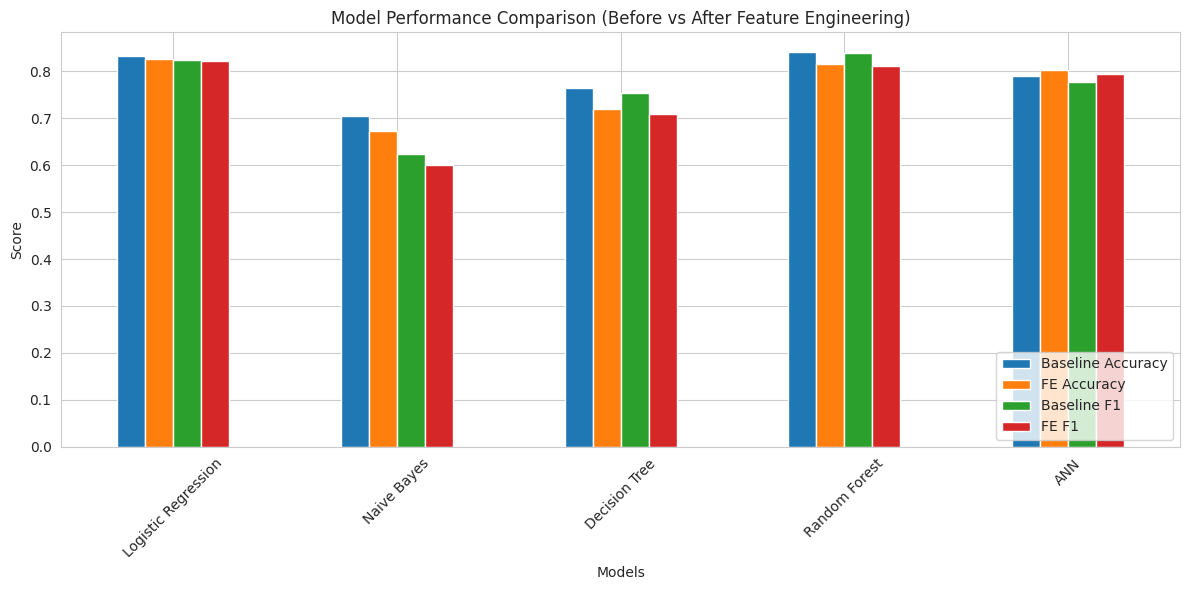

In [ ]:
# ===============================
# MODEL COMPARISON: BEFORE vs AFTER FEATURE ENGINEERING
# ===============================

print("=" * 80)
print("COMPARATIVE ANALYSIS: BASELINE vs FEATURE ENGINEERED MODELS")
print("=" * 80)

# Dictionary to store feature-engineered results
fe_results = {}

# Apply SMOTE on PCA-transformed training data
# (Note: Ideally SMOTE is applied before PCA; applied here due to pipeline constraints)
smote_pca = SMOTE(random_state=42, k_neighbors=5)
X_train_pca_balanced, y_train_pca_balanced = smote_pca.fit_resample(
    X_train_pca, y_train
)

print("\nTraining models on Feature-Engineered (PCA) data...\n")

for name, model in models.items():
    model.fit(X_train_pca_balanced, y_train_pca_balanced)
    y_pred_fe = model.predict(X_val_pca)

    fe_results[name] = {
        "Accuracy": accuracy_score(y_val, y_pred_fe),
        "Precision": precision_score(y_val, y_pred_fe),
        "Recall": recall_score(y_val, y_pred_fe),
        "F1": f1_score(y_val, y_pred_fe)
    }

    print(f"{name:20s} | "
          f"Acc: {fe_results[name]['Accuracy']:.4f} | "
          f"F1: {fe_results[name]['F1']:.4f}")

# -------------------------------
# Create Comparison DataFrame
# -------------------------------
comparison_df = pd.DataFrame({
    "Baseline Accuracy": [baseline_results[m]["Accuracy"] for m in models],
    "FE Accuracy": [fe_results[m]["Accuracy"] for m in models],
    "Baseline F1": [baseline_results[m]["F1"] for m in models],
    "FE F1": [fe_results[m]["F1"] for m in models]
}, index=models.keys())

print("\n" + "=" * 80)
print("COMPARISON TABLE")
print("=" * 80)
print(comparison_df.round(4))

# -------------------------------
# Visualization
# -------------------------------
comparison_df.plot(kind='bar', figsize=(12,6))
plt.title("Model Performance Comparison (Before vs After Feature Engineering)")
plt.ylabel("Score")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
